# Module: Data Science for Asset Management {-}

# Session 3: Time Series Analysis in Finance {-}

# Introduction

This session will focus on:
 - Introduction to financial time series: characteristics and challenges
 - Moving averages, autocorrelation, and stationarity in financial data
 - ARIMA and GARCH models for volatility prediction of financial time series
 - Apply time series forecasting (ARIMA, GARCH) to model volatility for Astra equity assets

# Dataset

As mentioned in Session 2, the historical datasets of this session (Open, High, Low, Close, Volumn) stock prices can be obtained by using the Yahoo Finance API **``yfinance``**. This API is free and simple to set up, but it still has a lot of data and options to provide. As shown in the previous session, we will download these prices using their tickers at 1-day intervals. 

## Installing & Importing Libraries 

Please install the 2 cells below for the [yfinance](https://pypi.org/project/yfinance/) and [arch](https://pypi.org/project/arch/) libraries if you do not already have them. As mentioned in the Session 2, you can install them by opening the Terminal via the newly created Python environment in the Anaconda Navigator. If you do not remeber the process of creating a Python environment, please study the Session 0 Python Basics by watching the YouTube playlist step by step carefully. 

In [1]:
!pip install arch
!pip3 install yfinance

In [2]:
# Importing Python librarys for data visualization and numerical analyses
# If you do not understand the following lines, please study the Session 0 Python Basics step by step carefully 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats
import sklearn
from arch import arch_model
import yfinance as yf

%matplotlib inline

In [3]:
# Turn off all the warning messages
# As mentioned in the Session 0 Python Basic and Session 2, warning messages are useful for refining the coding in the future
# However, we may ignore the warning messages at this initial stage, so we can focus on the big picture
import warnings
warnings.filterwarnings('ignore')

In [4]:
# NOTE: more likely, you need install the scikit-learn Python library, a powerful machine learning library
# The library name is scikit-learn, but when importing it, we can use its short name sklearn
# Reference: https://scikit-learn.org/stable/

# We also need install statsmodels Python library, see: https://pypi.org/project/statsmodels/

# Getting financial data
import yfinance as yf

# Indexation of time
from datetime import datetime, timedelta

# The measures of performances 
from sklearn.metrics import mean_squared_error as mse
#from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Libraries of Autocorrelation and Partial Autocorrelation for identifier lag of GARCH model
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
#from statsmodels.tsa.stattools import adfuller

In [5]:
# Python libraries for implementing GARCH modeling
from arch import arch_model
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from scipy.stats import probplot, moment

In [6]:
# To see all of the text, change the column width in pandas
# (Model performance will be shown later)
pd.set_option('display.max_colwidth', None)

In [7]:
# Pre-set the path to the image  to save plots later
directory_to_img = os.path.join('..', '..', 'images')

## Load Data from `yfinance`

In [8]:
# For reproducibility, we're going to fix set seed
# Reference: https://medium.com/@abhishekjainindore24/seeding-success-a-guide-to-setting-seeds-in-data-science-5d24e00c3dc7
# Reference: https://medium.com/data-science/random-seeds-and-reproducibility-933da79446e3
seed = 2025

In [9]:
# Select start and end date for the dataset (i.e. 5 years)
start = datetime(2020, 1, 1)
end = datetime(2025, 1, 1)

# Choose the stock or market index, for example, S&P 500 (the ticker is ^GSPC), see https://uk.finance.yahoo.com/quote/%5EGSPC/  
tckr = '^GSPC'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

# Or, you may use the same way as in the Session 2 to download the dataset
# df_GSPC = yf.download("^GSPC", start="2020-01-01", end="2025-01-01", group_by="ticker") # Market index of S&P 500

In [10]:
df.shape

(1258, 7)

We have 1258 observation numbers/rows and 7 variables/columns (Open, High, Low, Close, Volume, Dividends, Stock Splits), and our data set in the format of a time series, from  01 Jan. 2020 to 30 Dec. 2024.

In [11]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,3244.669922,3258.139893,3235.530029,3257.850098,3459930000,0.0,0.0
2020-01-03 00:00:00-05:00,3226.360107,3246.149902,3222.340088,3234.850098,3484700000,0.0,0.0
2020-01-06 00:00:00-05:00,3217.550049,3246.840088,3214.639893,3246.280029,3702460000,0.0,0.0
2020-01-07 00:00:00-05:00,3241.860107,3244.909912,3232.429932,3237.179932,3435910000,0.0,0.0
2020-01-08 00:00:00-05:00,3238.590088,3267.070068,3236.669922,3253.050049,3726840000,0.0,0.0


In [15]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-12-24 00:00:00-05:00,5984.629883,6040.100098,5981.439941,6040.040039,1757720000,0.0,0.0
2024-12-26 00:00:00-05:00,6024.970215,6049.750000,6007.370117,6037.589844,2904530000,0.0,0.0
2024-12-27 00:00:00-05:00,6006.169922,6006.169922,5932.950195,5970.839844,3159610000,0.0,0.0
2024-12-30 00:00:00-05:00,5920.669922,5940.790039,5869.160156,5906.939941,3433250000,0.0,0.0
2024-12-31 00:00:00-05:00,5919.740234,5929.740234,5868.859863,5881.629883,3128350000,0.0,0.0


We will remove the two columns ``Dividends`` and ``Stock Splits`` because they don't contain any information and all of the rows are ``0.0``. 

In [16]:
# NOTE: in Session 0 Python Basics, you have learnt these basic functions to modify the Pandas data format, such as df.drop()
df = df.drop(['Dividends', 'Stock Splits'], axis=1)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,3244.669922,3258.139893,3235.530029,3257.850098,3459930000
2020-01-03 00:00:00-05:00,3226.360107,3246.149902,3222.340088,3234.850098,3484700000
2020-01-06 00:00:00-05:00,3217.550049,3246.840088,3214.639893,3246.280029,3702460000
2020-01-07 00:00:00-05:00,3241.860107,3244.909912,3232.429932,3237.179932,3435910000
2020-01-08 00:00:00-05:00,3238.590088,3267.070068,3236.669922,3253.050049,3726840000


**Descriptive Statistics**

Let’s print some **statistics**, such as the mean, median, min, max and standard deviation values for the above features (columns).

In [17]:
df.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,4258.915009,4283.980701,4232.242692,4259.606933,4.376287e+09
std,767.478053,765.438426,769.613238,767.448592,1.052113e+09
min,2290.709961,2300.729980,2191.860107,2237.399902,0.000000e+00
25%,3817.265015,3846.012512,3791.585022,3819.052551,3.751010e+09
50%,4206.094971,4233.785156,4186.004883,4204.880127,4.113210e+09
75%,4602.849854,4631.122681,4579.504883,4603.890137,4.712908e+09
max,6089.029785,6099.970215,6079.979980,6090.270020,9.976520e+09


# Visualization and Data Preprocessing

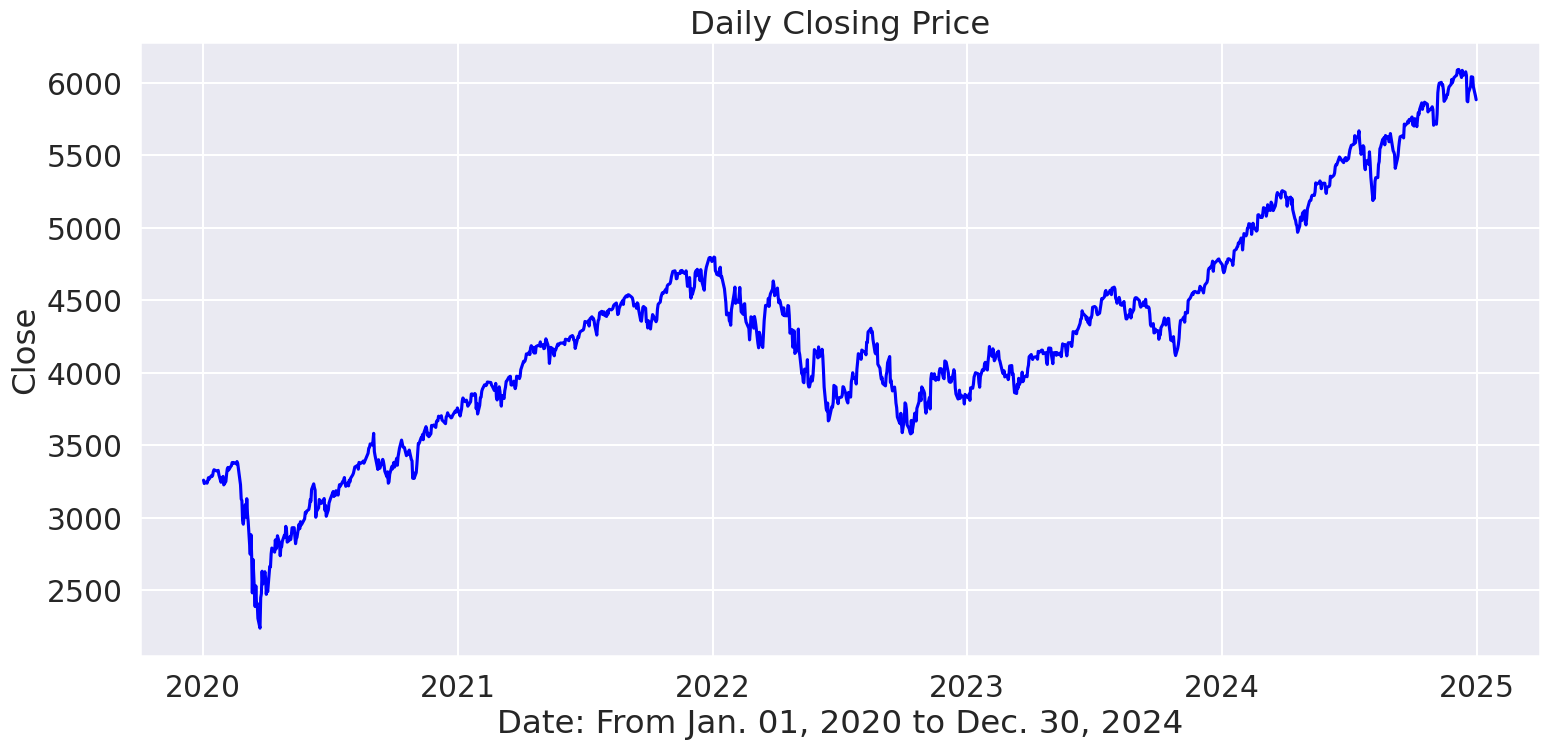

In [12]:
# Set context for the poster and font size
sns.set_context("talk", font_scale=1.3)

# Plot out the stock's closing prices
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(16,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('Daily Closing Price')
    ax.set_xlabel('Date: From Jan. 01, 2020 to Dec. 30, 2024')    

plt.tight_layout()

plt.show()

# If you want to save this plot as a png file in your computer
#plt.savefig(os.path.join('close.png'), dpi=300, bbox_inches='tight')

The figure above represents the financial time series. The first observations we can take from this time series are the following:

- The daily time series has an increasing trend and we can also see many fluctuations
- We can use the log of the time series to remove this variation of amplitude in the series
- The time series is not stationary, the variance is not constant over time
- We also see a large fall because of the COVID-19 crisis

# Stationarity study 

- A time series is said to be stationary, if statistical features like mean and variance do not change over time.

- The majority of time series models assume that the time series is stationary. The main reason for this is that while there are many ways for a series to be non-stationary, there is only one method for it to be stationary.

- Intuitively, we may conclude that if a time series shows a certain pattern across time, there is a very good chance that it will continue to do so in the future.

- In addition, compared to non-stationary series, stationary series theories are more developed and easier to apply.

- Reference: https://hex.tech/blog/stationarity-in-time-series/

__The following methods can be used to determine stationarity:__

- __ACF and PACF Plots__: If the time series is stationary, the ACF/PACF plots will show a __rapid drop in correlation__ after a short lag between points.
  
- __Augmented Dickey-Fuller (ADF) Test__: it is a statistical test for determining stationarity. The time series is non-stationary, according to the null hypothesis ($H_0$). A test statistic and several crucial values for different confidence levels are included in the test findings. If the 'Test Statistic' is smaller than the 'Critical Value', the null hypothesis is rejected, and the series is said to be stationary. 

- __Plotting Rolling Statistics__: The rolling average or moving variance can be plotted to examine how it changes over time. For any instant 't', the moving average/variance of the previous year, i.e. the last 12 months.

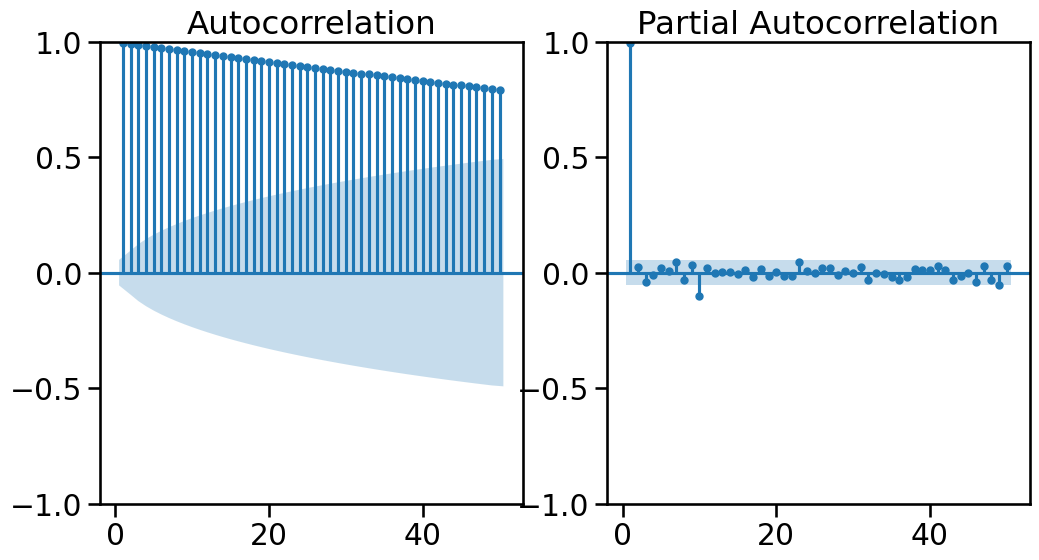

In [19]:
plt.rcParams["figure.figsize"] = 12, 6
fig, axes = plt.subplots(1, 2, sharex=True)
sgt.plot_acf(df.Close, ax=axes[0],zero=False,lags=50);
sgt.plot_pacf(df.Close, ax=axes[1],zero=False,lags=50);
plt.show()

### Analysis of ACF and PACF plots

- Let's have a look at the plots of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF). The ACF/PACF plots will indicate a __quick drop-off in correlation__ after a small amount of lag between points, if the time series is stationary. 

- Since many of the previous observations are related to future values, this indicates that the data series is non-stationary. 

- A cone is used to represent confidence intervals. By default, this is set to a $95\%$ confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

- The partial autocorrelation at lag $k$ is the correlation that remains after any correlations attributable to terms at shorter lags have been removed.

> We can see from our ACF and PACF plots that the series is not stationary, and more likely a partial autocorrelation at lag k=1.

### The principle behind the Augmented Dickey-Fuller Test is as follows:

- If the series is integrated, the lagged level of the series $y_{t−1}$ will provide no useful information for predicting the change in $y_t$, according to the test's definition.

- Null hypothesis ($H_0$): The time series is not stationary.

- Rejecting the null hypothesis (i.e. a very low ``p-value``) will indicate stationary.

In [20]:
#Perform Dickey-Fuller test:
print ('Results of Augmented Dickey-Fuller Test:')
dftest = adfuller(df.Close, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic                   -0.343447
p-value                           0.919121
#Lags Used                       10.000000
Number of Observations Used    1247.000000
Critical Value (1%)              -3.435605
Critical Value (5%)              -2.863861
Critical Value (10%)             -2.568005
dtype: float64


The results of the ADF test are shown above. At the $5\%$ significance level, the null hypothesis ($H_0$) of the existence of a unit root in the series of the close price of the stock/index is accepted (because the ``p-value`` (0.919121) is higher than $5\%$). These results indicate that the close price series is not stationary.

### Plotting Rolling Statistics: 

The rolling average or moving variance can be plotted to examine how it changes over time. For any instant 't', the moving average/variance of the previous year, i.e. the last 12 months. We create a function of plotting rolling statistics below, it will be used in the cells later.

In [21]:
def test_stationarity(timeseries):
    #determine rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=22).mean() #22 trading days in each month
    rolstd = pd.Series(timeseries).rolling(window=22).std()
    #plot rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label='original')
    mean = plt.plot(rolmean, color = 'red', label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label = 'rolling std')
    plt.legend(loc = 'best')
    plt.title('Rolling mean and standard deviation of Asset Return')
    plt.show(block = False)
    #perform dickey fuller test
    print('result of dickey fuller test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test statistics', 'p-value', '#lags used', 'number of observation used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key] = value
    print(dfoutput)

## Making time series stationary

There are 2 major reasons behind the non-stationary of a time series:

1. __Trend__ – Varying means over time. For example in our case, we saw that on average, the number of close prices was growing over time.

2. __Seasonality__ – Variations at specific time-frames. e.g. people may be more likely to buy ice cream in a specific month as a result of a hot weather.

### Returns and Log Returns

**Simple Return**

$$r_t=\frac{P_t-P_{t-1}}{P_{t-1}}$$

In [22]:
# Calculate price returns as daily percentage change using pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

Log returns are generally preferred for practical reasons, particularly in financial mathematical modeling, because they help to eliminate non-stationary features of time series data and make it more stable: 

**Log Returns** formula:

$$r_{t, t+i} = \log\Big{(}\frac{P_{t+i}}{P_{t}}\Big{)}$$


In [23]:
# Calculate log returns based on above formula
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [24]:
df.head()

,Open,High,Low,Close,Volume,returns,log_returns
Date,,,,,,,
2020-01-02 00:00:00-05:00,3244.669922,3258.139893,3235.530029,3257.850098,3459930000,NaN,NaN
2020-01-03 00:00:00-05:00,3226.360107,3246.149902,3222.340088,3234.850098,3484700000,-0.705987,-0.007085
2020-01-06 00:00:00-05:00,3217.550049,3246.840088,3214.639893,3246.280029,3702460000,0.353337,0.003527
2020-01-07 00:00:00-05:00,3241.860107,3244.909912,3232.429932,3237.179932,3435910000,-0.280324,-0.002807
2020-01-08 00:00:00-05:00,3238.590088,3267.070068,3236.669922,3253.050049,3726840000,0.490245,0.004890


Checking if there are any missing values:

In [25]:
df.isnull().sum()

Open           0
High           0
Low            0
Close          0
Volume         0
returns        1
log_returns    1
dtype: int64

First value of the table is equal to NaN because, $P_t−P_{t−1} = NaN$ and Simple Return $R_t = \frac{P_t−P_{t−1}}{P_{t−1}} = NaN$

> Let’s dropping the 1st row of data, because we shifted it forward to calculate returns and log returns.



In [26]:
df.dropna(inplace=True)

### Squared Returns (Volatility)

In [27]:
df['Sq_Returns']=df.returns.mul(df.returns)
df.head()

,Open,High,Low,Close,Volume,returns,log_returns,Sq_Returns
Date,,,,,,,,
2020-01-03 00:00:00-05:00,3226.360107,3246.149902,3222.340088,3234.850098,3484700000,-0.705987,-0.007085,0.498418
2020-01-06 00:00:00-05:00,3217.550049,3246.840088,3214.639893,3246.280029,3702460000,0.353337,0.003527,0.124847
2020-01-07 00:00:00-05:00,3241.860107,3244.909912,3232.429932,3237.179932,3435910000,-0.280324,-0.002807,0.078581
2020-01-08 00:00:00-05:00,3238.590088,3267.070068,3236.669922,3253.050049,3726840000,0.490245,0.004890,0.240340
2020-01-09 00:00:00-05:00,3266.030029,3275.580078,3263.669922,3274.699951,3641230000,0.665526,0.006633,0.442925


Now we want to plot distribution plots of returns and log returns, as well as visually compare them with the standard normal distribution.


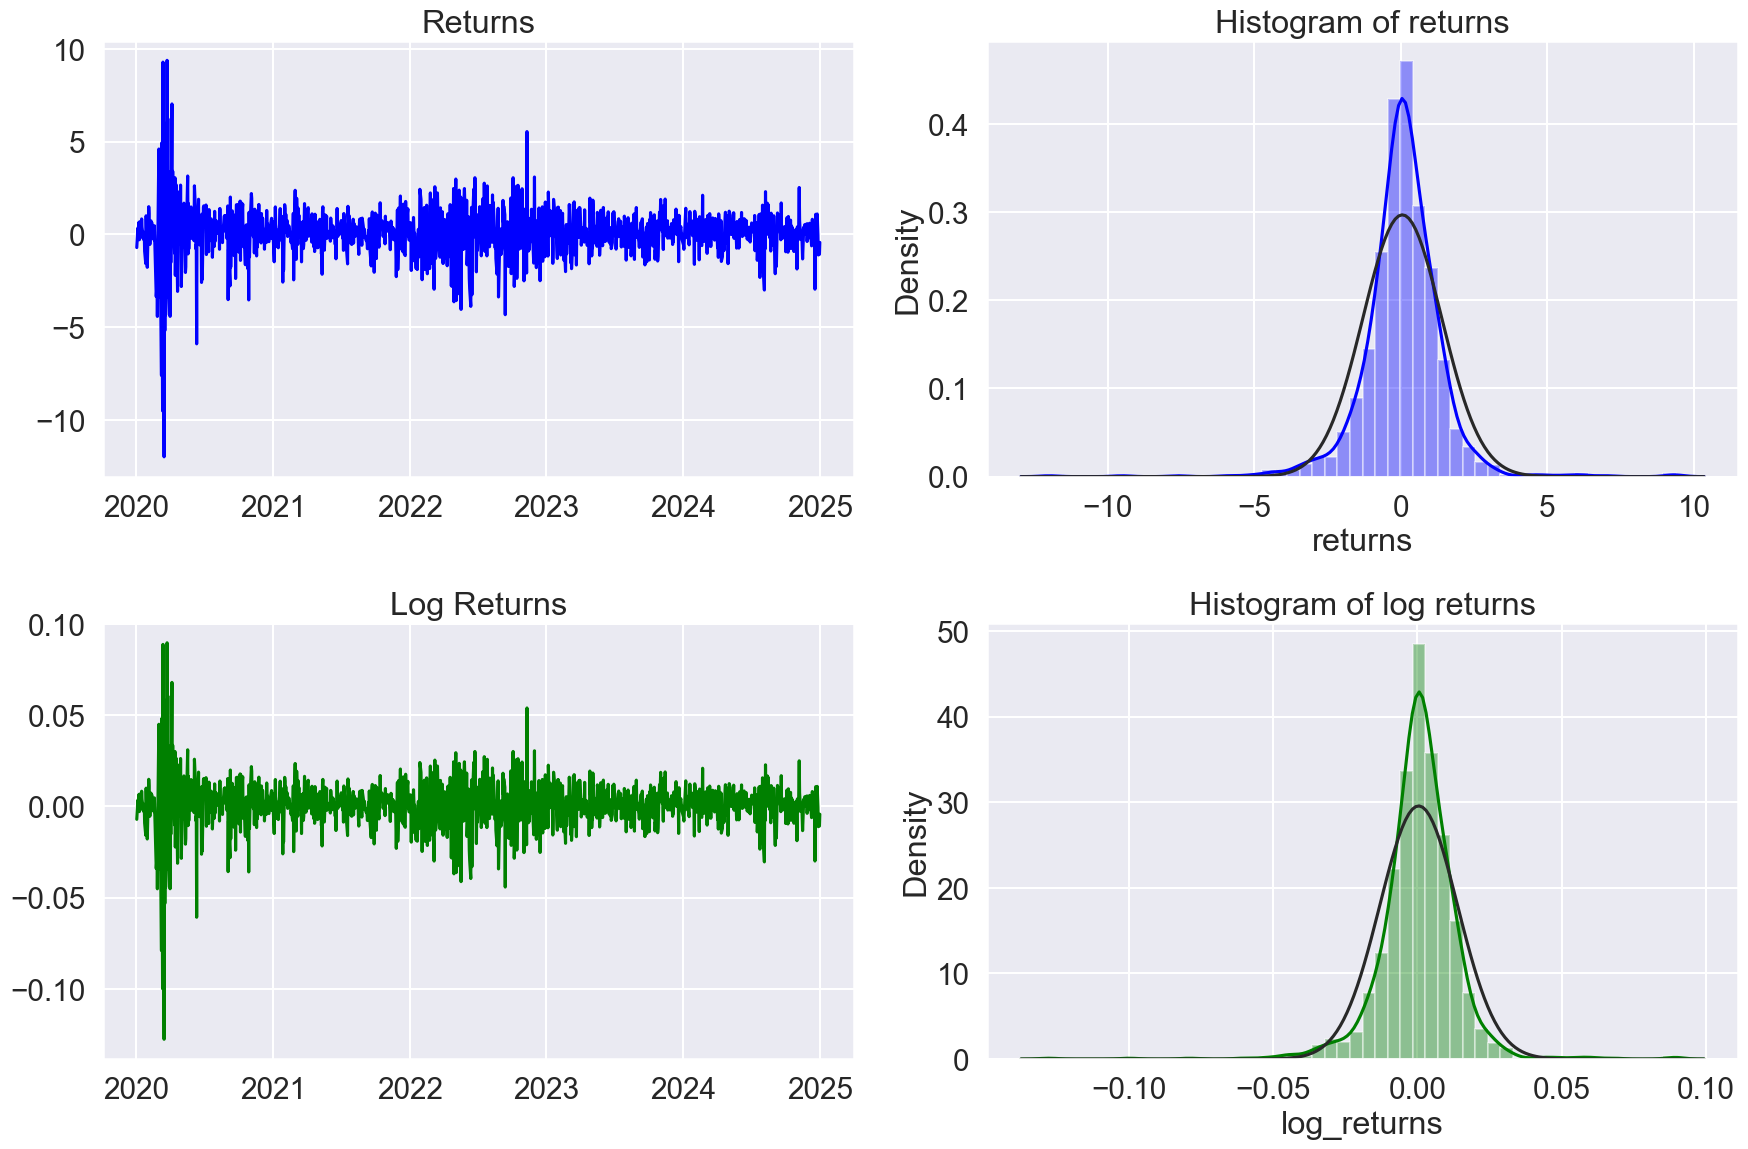

In [28]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Histogram of returns')

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Histogram of log returns')
    plt.tight_layout()
    plt.show()
    #If you want to save the plot as a png in your current computer folder
    #plt.savefig(os.path.join( 'returns_logreturns.png'), dpi=300, bbox_inches='tight')
    #fig.show();


Some observations are shown in both Returns and Log Returns:

- There is a slight negative skewness in the series, as mentioned in the previous sessions (also in other modules).

- Positive kurtosis (leptokurtic) - a distribution with a higher peak and thicker tails than a standard normal distribution. 

> We can see from our plots return and log return that the series is stationary, and we see a trend despair and a very significant peak at the beginning of 2020 due to the COVID-19 crisis.

In [29]:
df.returns.describe()

count    1257.000000
mean        0.056087
std         1.344289
min       -11.984055
25%        -0.530656
50%         0.088779
75%         0.726579
max         9.382774
Name: returns, dtype: float64

In [30]:
df.log_returns.describe()

count    1257.000000
mean        0.000470
std         0.013500
min        -0.127652
25%        -0.005321
50%         0.000887
75%         0.007240
max         0.089683
Name: log_returns, dtype: float64

### Returns vs. Squared Returns

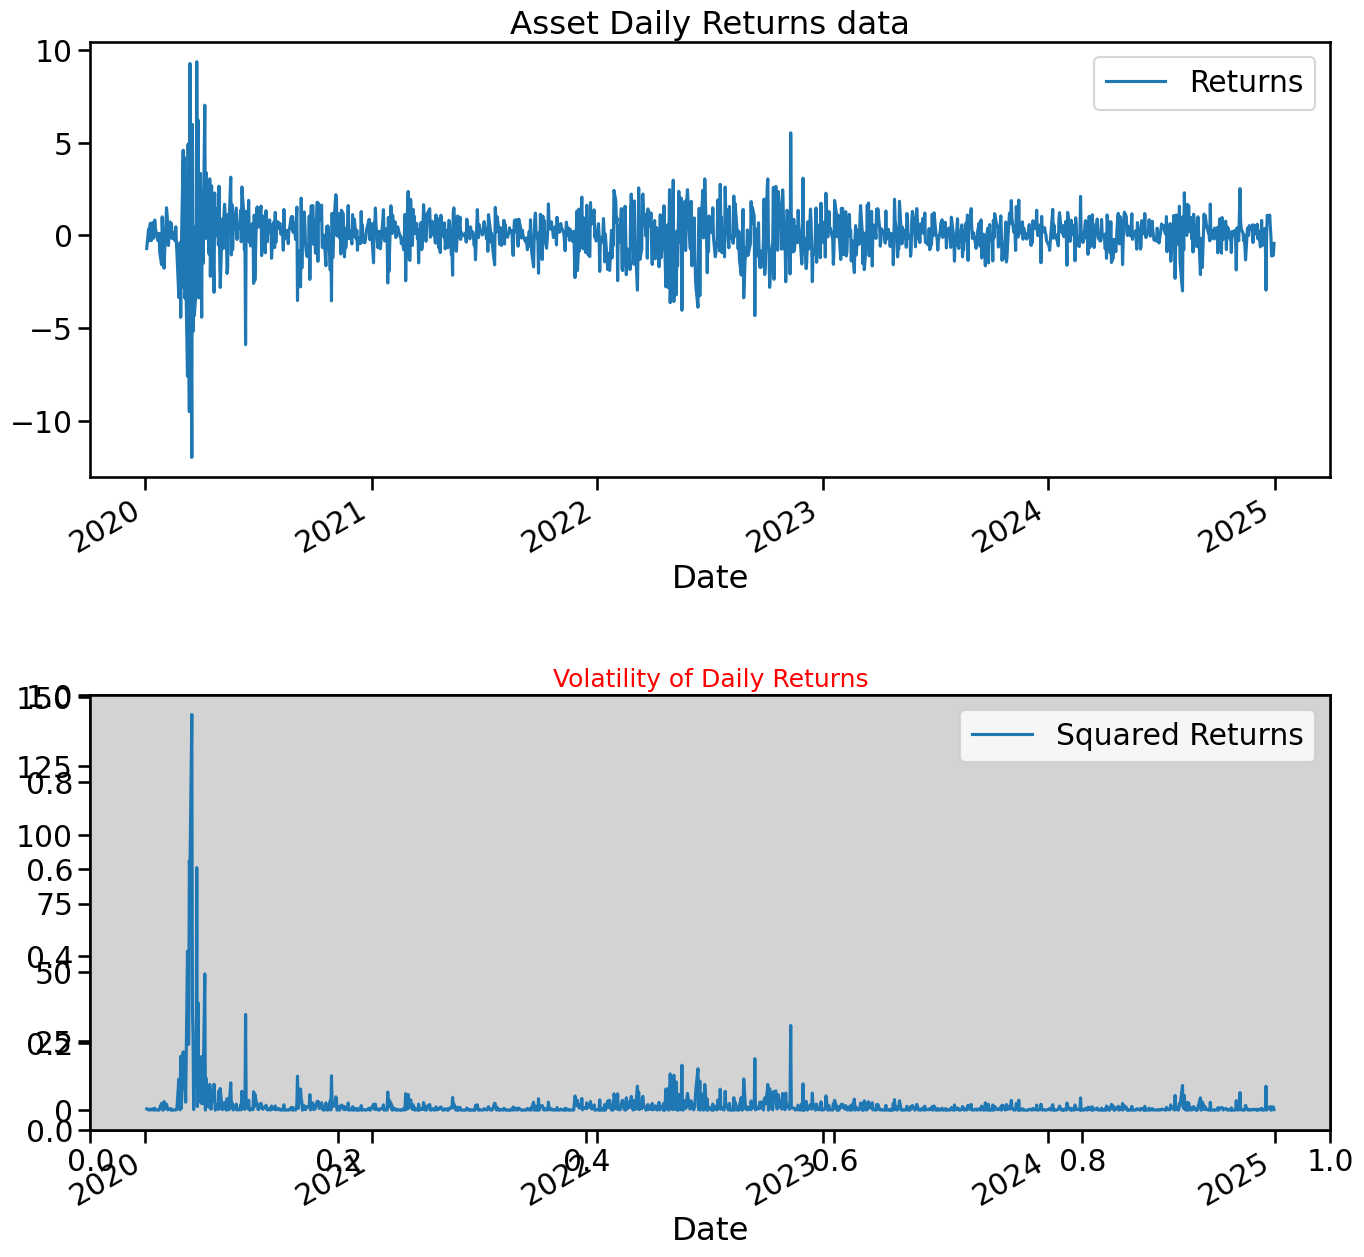

In [31]:
#Plot the Daily Returns
plt.figure(figsize=(16, 16))
plt.subplot(211)
df['returns'].plot(label='Returns')
plt.title('Asset Daily Returns data')
plt.legend()
#Plot the Daily Squared Returns
plt.subplot(212)
plt.subplot(212, facecolor="lightgrey")
df['Sq_Returns'].plot(label='Squared Returns')
plt.title('Volatility of Daily Returns',color="red",fontsize=18,ha='center')
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)
plt.show()

> We show from plot bursts the volatility of Returns, which means the periods of low positive and negative returns are expressed with low volatility, while those with sharp jumps or drops have high uncertainty.

### **Returns and Log Returns: stationarity checking**


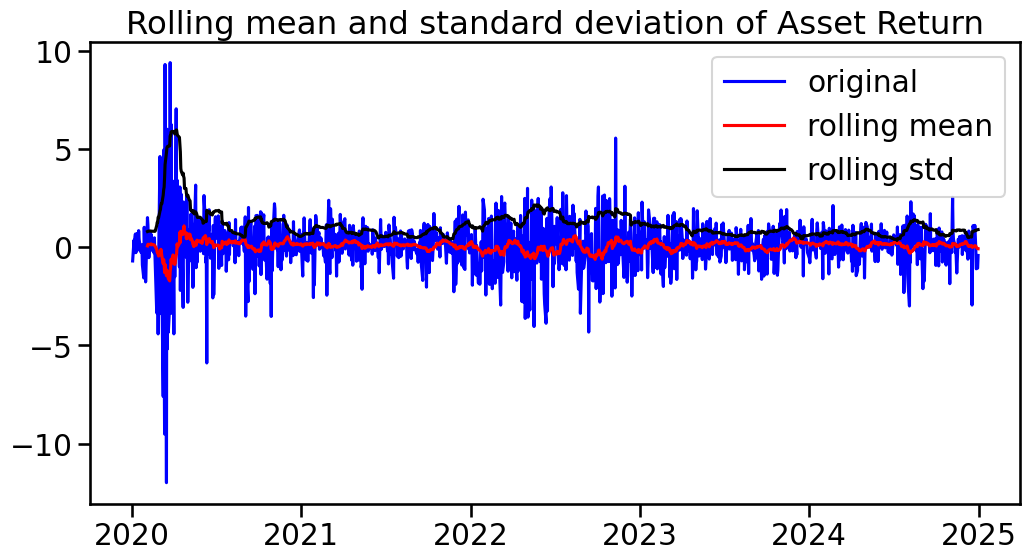

result of dickey fuller test:
Test statistics              -1.070801e+01
p-value                       3.388308e-19
#lags used                    8.000000e+00
number of observation used    1.248000e+03
critical value (1%)          -3.435601e+00
critical value (5%)          -2.863859e+00
critical value (10%)         -2.568004e+00
dtype: float64


In [32]:
#rcParams['figure.figsize'] = 15,10
df['returns'].dropna(inplace=True)
test_stationarity(df['returns'])

From plots above we can see that the trend does not appear! This means that the series is stationary now, with the confirmation of the increased Dickey-Fuller test (p-value lower than $1\%$), so we obtain a stationary series.

In [33]:
# For log returns
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -10.605829726961135
p-value: 6.006407362546278e-19
Critical Values:
1%: -3.4356
5%: -2.8639
10%: -2.5680


Using a significant level alpha of 0.05, `p-value` for both Returns and Log Returns are significantly smaller than the alpha, which means there is enough evidence to reject the Null Hypothesis. Therefore, this shows that Returns and Log_Returns are both not dependent on time/trend.

# Train-Test Splits

In [34]:
# Currently, our dataset has the following shape (rows, columns)
df.shape

(1257, 8)

There're a total of 1257 usable datapoints/rows in this dataset which covers a period of almost 5 years from January 2020 until December 2024.

We will split the dataset into 2 parts as follows:

- The most recent 250 usable datapoints would be used for **Final Model Testing - approx. 20%** (or trading days in one year)

- And the remaining for **Training - approx. 80%** (or trading days in the past four years)

First, we will build a new database when we just put the variable "Return"

In [35]:
data_return= df[["returns"]]

In [36]:
# Pre-determine desired test & validation sizes
test_size = 250

# Convert to indices
split_time = len(data_return) - test_size

# Get corresponding datetime indices for each set
train_idx = df.index[:split_time]
test_idx = df.index[split_time:]

In [37]:
print(f'TRAINING data period: \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'TEST data period: \tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING data period: 	From: 2020-01-03 00:00:00-05:00 	to: 2024-01-03 00:00:00-05:00 	1007 days
TEST data period: 	From: 2024-01-04 00:00:00-05:00 	to: 2024-12-31 00:00:00-05:00 	250 days


In [38]:
# Split returns into 2 parts (this would be the input for GARCH models)
r_train = data_return.returns[train_idx]
r_test = data_return.returns[test_idx]

In [39]:
r_train.describe()

count    1007.000000
mean        0.047045
std         1.448644
min       -11.984055
25%        -0.606767
50%         0.081998
75%         0.751093
max         9.382774
Name: returns, dtype: float64

In [40]:
r_train

Date
2020-01-03 00:00:00-05:00   -0.705987
2020-01-06 00:00:00-05:00    0.353337
2020-01-07 00:00:00-05:00   -0.280324
2020-01-08 00:00:00-05:00    0.490245
2020-01-09 00:00:00-05:00    0.665526
                               ...   
2023-12-27 00:00:00-05:00    0.143046
2023-12-28 00:00:00-05:00    0.037017
2023-12-29 00:00:00-05:00   -0.282648
2024-01-02 00:00:00-05:00   -0.566058
2024-01-03 00:00:00-05:00   -0.801631
Name: returns, Length: 1007, dtype: float64

In [41]:
r_test

Date
2024-01-04 00:00:00-05:00   -0.342838
2024-01-05 00:00:00-05:00    0.182569
2024-01-08 00:00:00-05:00    1.411463
2024-01-09 00:00:00-05:00   -0.147790
2024-01-10 00:00:00-05:00    0.566597
                               ...   
2024-12-24 00:00:00-05:00    1.104276
2024-12-26 00:00:00-05:00   -0.040566
2024-12-27 00:00:00-05:00   -1.105574
2024-12-30 00:00:00-05:00   -1.070200
2024-12-31 00:00:00-05:00   -0.428480
Name: returns, Length: 250, dtype: float64

**Another method to split the series**

In [42]:
#Train and test split
#Splitting the dataset into 80% training set and 20% Test set
print(data_return.shape)
train = data_return.iloc[:-test_size]
test = data_return.iloc[-test_size:]
print(train.shape,test.shape)

(1257, 1)
(1007, 1) (250, 1)


In [43]:
test

,returns
Date,
2024-01-04 00:00:00-05:00,-0.342838
2024-01-05 00:00:00-05:00,0.182569
2024-01-08 00:00:00-05:00,1.411463
2024-01-09 00:00:00-05:00,-0.147790
2024-01-10 00:00:00-05:00,0.566597
...,...
2024-12-24 00:00:00-05:00,1.104276
2024-12-26 00:00:00-05:00,-0.040566
2024-12-27 00:00:00-05:00,-1.105574


###  Train-Test Visualization

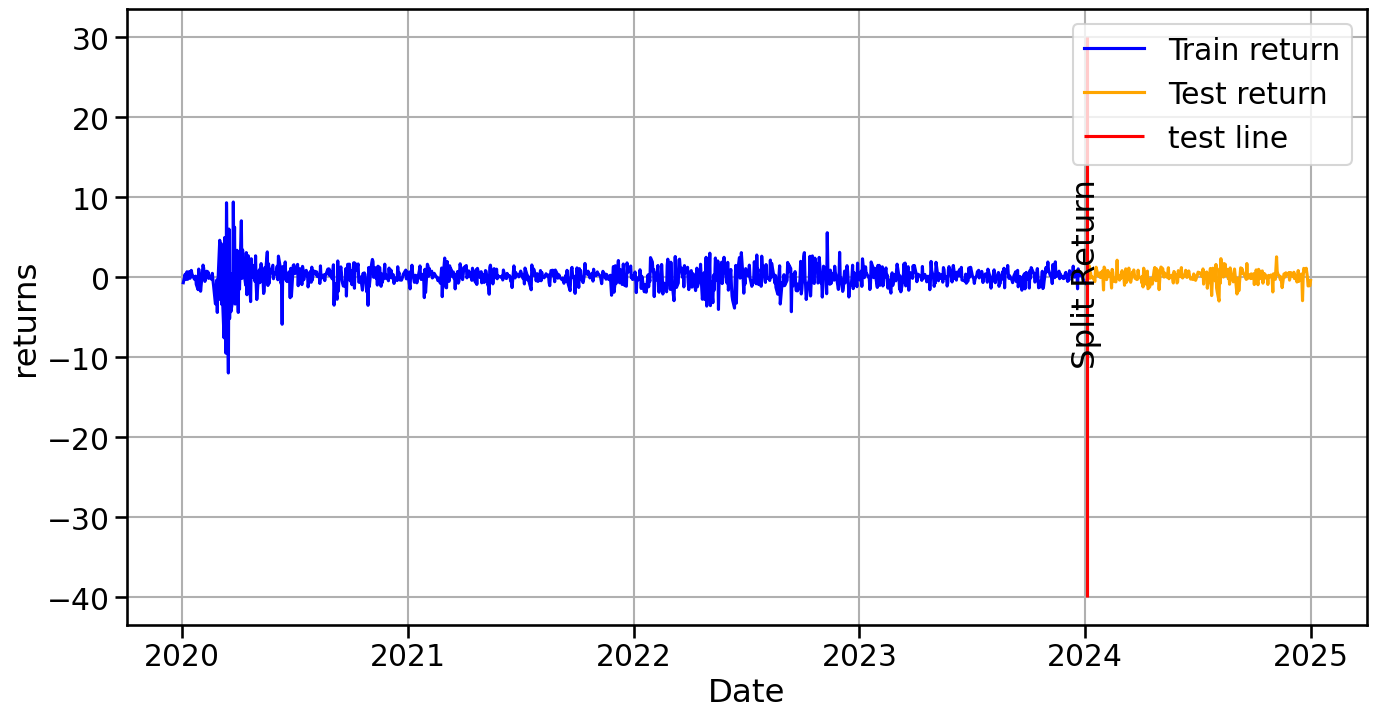

In [44]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('returns')
plt.plot(train['returns'], 'blue', label='Train return')
plt.plot(test['returns'], 'orange', label='Test return')
plt.vlines(x=[datetime(2024, 1, 4)], ymin=-40, ymax=30, color='r', label='test line')
plt.text(datetime(2024, 1, 4), 0.488787, 'Split Return', ha='center', va='center',rotation='vertical')
plt.legend()
plt.show()

### Correlogram Plot


**Hurst Exponent function**

The ``Hurst Exponent`` is a statistical measure used to classify time series and infer the level of difficulty in predicting and choosing an appropriate model for the series at hand. The Hurst exponent is used as a measure of long-term memory of time series. It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases.

*    Value near ``0.5`` indicates a random series.
*    Value near ``0`` indicates a mean reverting series.
*    Value near ``1`` indicates a trending series.


In [45]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [46]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=0.1, y=1.5, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
   
    axes[0][1].text(x=.4, y=1.4, s=s, transform=axes[0][1].transAxes)
  
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9,hspace=1.5)
    plt.show()

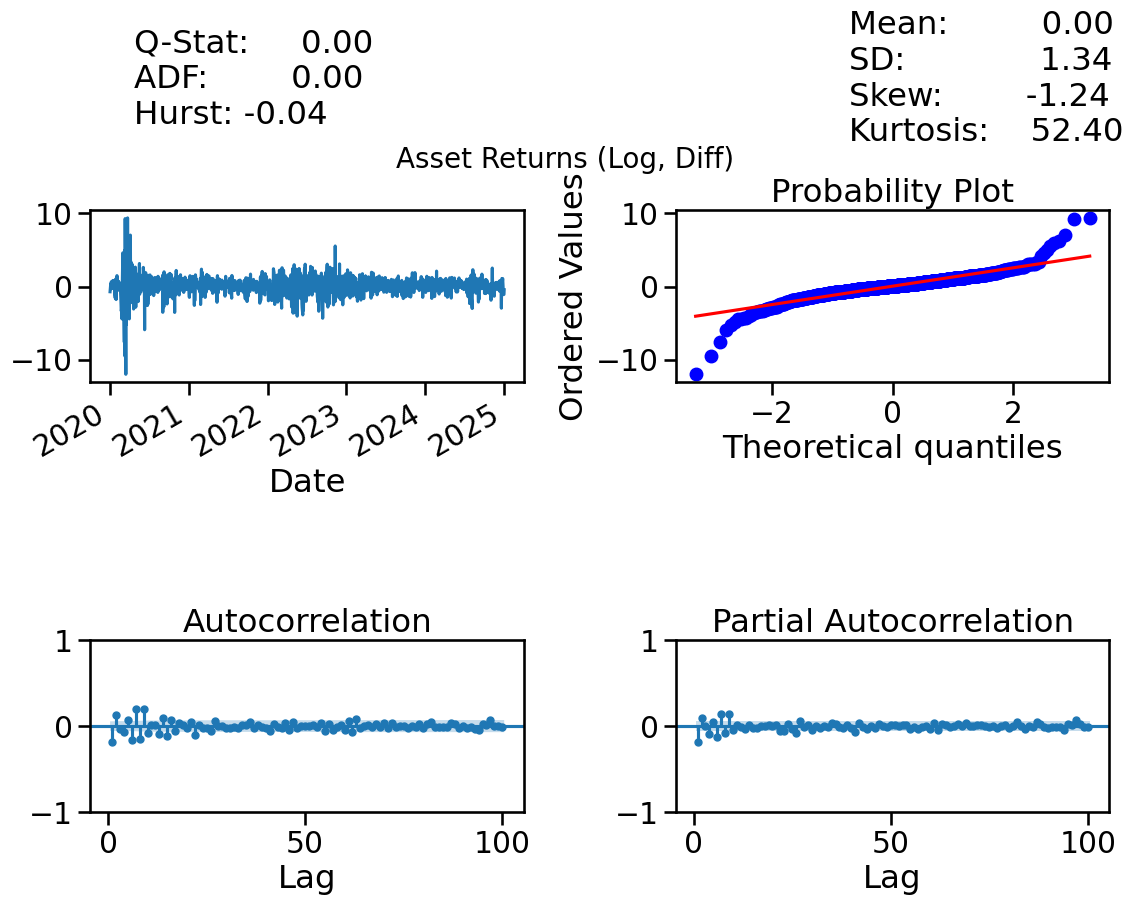

In [47]:
# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(df['returns'], lags=100, title='Asset Returns (Log, Diff)')

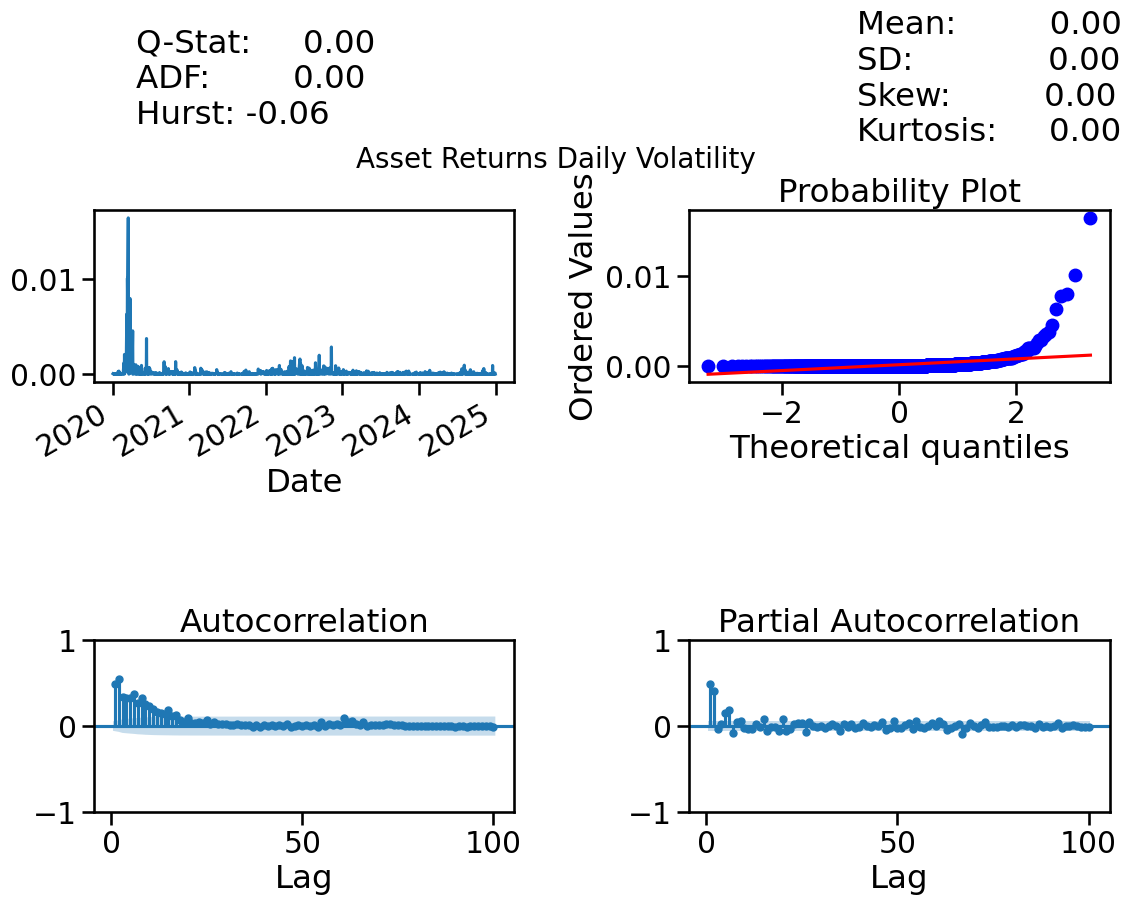

In [48]:
plot_correlogram(df.log_returns.sub(df.log_returns.mean()).pow(2), lags=100, title='Asset Returns Daily Volatility')

# MODELING


##  GARCH Model


The GARCH model, which is an extension of the ARCH model (Autoregressive Conditional Heteroskedasticity), stands for **Generalized Autoregressive Conditional Heteroskedasticity**.


The standard econometric approach to financial time series volatility prediction is GARCH, which includes lag variance terms with lag residual errors from a mean process.


GARCH can be represented mathematically as follows:

\begin{align}
\sigma_{t}^2 = \omega + \sum_{i=1}^{q}\alpha_{i}\epsilon_{t-i}^2 + \sum_{i=1}^{p}\beta_{i}\sigma_{t-i}^2
\end{align}

in which $\sigma_{t}^2$ is variance at time step `t` and $\epsilon_{t-i}^2$ is the model residuals at time step `t-1`.

GARCH(1,1) only contains first-order lagged terms and the mathematic equation for it is: 

\begin{align}
\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}
\end{align}

where $\alpha$, $\beta$ and $\omega$ sum up to 1, and $\omega$ is the long term variance.

**Note**: Since some professionals in the subject of volatility consider GARCH to be an effective improvement over simply assuming future volatility will be the same as it was in the past, it is also frequently overstated as a predictor by some.
The important components of volatility are captured by GARCH models: volatility tomorrow will be similar to today (**clustering**), and volatility in the long run will most probably **mean revert** (meaning it will be similar to whatever the historical long-term average has been). 

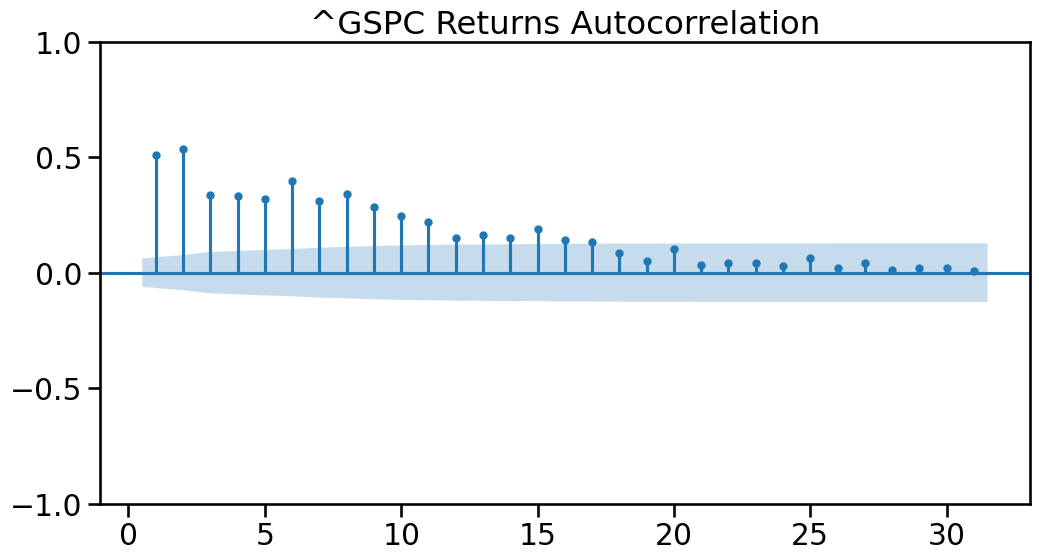

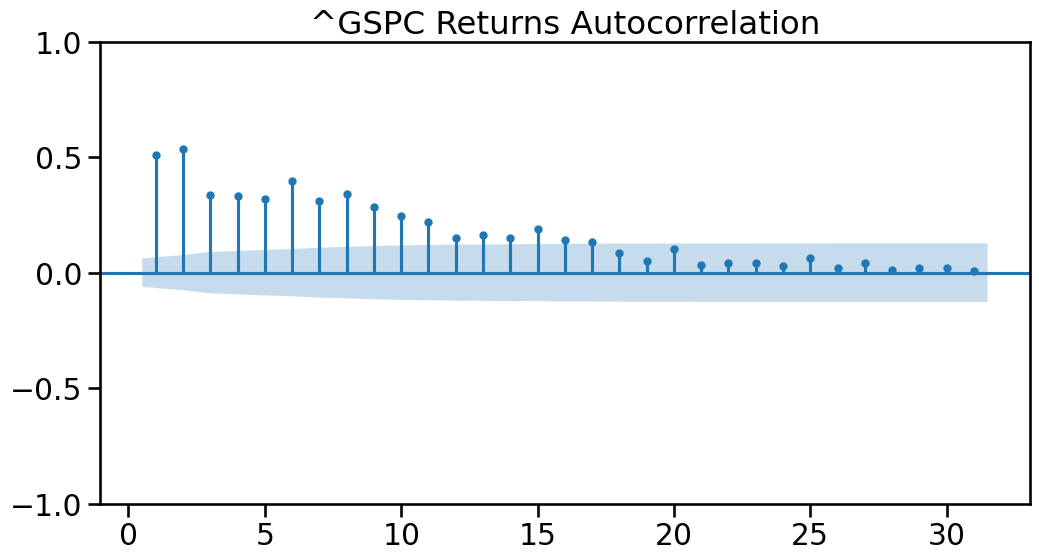

In [49]:
# Visualize autocorrelation of squared returns
plot1 = plot_acf(r_train**2, title=f'{tckr.upper()} Returns Autocorrelation',zero=False);
plot1

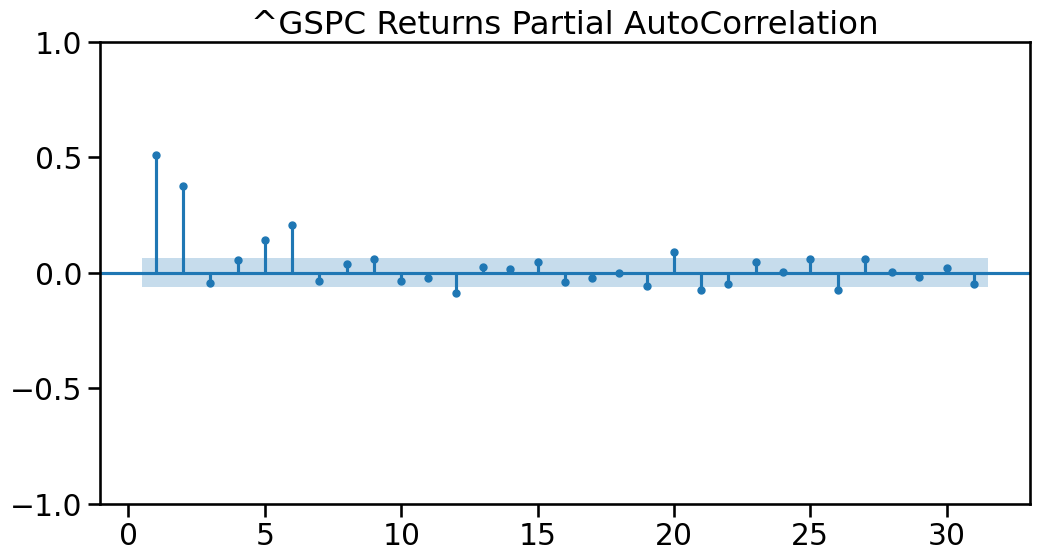

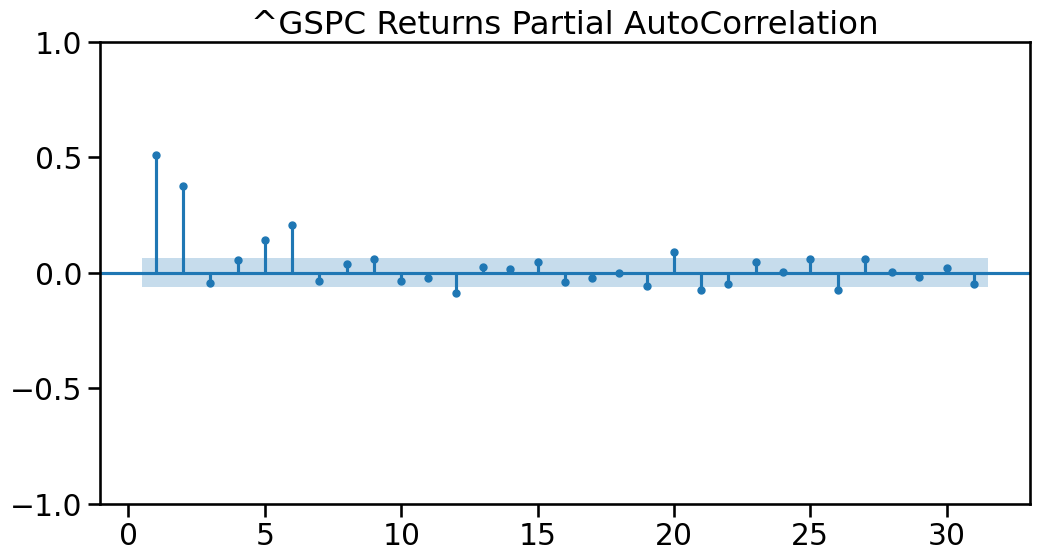

In [50]:
# Visualize partial autocorrelation of squared returns
plot2 = plot_pacf(r_train**2, title=f'{tckr.upper()} Returns Partial AutoCorrelation',zero=False);
plot2

The autocorrelation plots seem to indicate that there's only significant correlation up to the 1st, 2nd, 5th, 6th lags, and the ones following don't seem to be too significant. So the models that we want to suggest are the following: 

*  **$1^{st}$ model**: GARCH(1,1) model.
*  **$2^{nd}$ model**: GARCH(5,5) model.

**$1^{st}$ Model**

In [51]:
# Set seed for reproducibility
# NOTE: the seed is set in the beginning of this notebook, see the first cell after Load Data from `yfinance` 
np.random.seed(seed)

# Reference: https://arch.readthedocs.io/en/stable/univariate/introduction.html
model_garch_1 = arch_model(r_train, p=1, q=1)
result_1 = model_garch_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1536.59
Distribution:                  Normal   AIC:                           3081.19
Method:            Maximum Likelihood   BIC:                           3100.85
                                        No. Observations:                 1007
Date:                Fri, Oct 10 2025   Df Residuals:                     1006
Time:                        16:00:13   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0806  3.052e-02      2.641  8.262e-03 [2.079e-

> Using a significance level of $0.05$, all coefficients look statistically significant.

**$2^{nd}$ Model**

In [52]:
model_garch_2 = arch_model(r_train, vol='GARCH', p=5, q=5)
result_2 = model_garch_2.fit(disp='off')
print()
print(result_2.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1535.84
Distribution:                  Normal   AIC:                           3095.69
Method:            Maximum Likelihood   BIC:                           3154.66
                                        No. Observations:                 1007
Date:                Fri, Oct 10 2025   Df Residuals:                     1006
Time:                        16:00:13   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0782  3.280e-02      2.384  1.713e-02 [1.390e-

> Only alpha[1] seems to be statistically significant (because other p-values (`P > |t|`) are all greater than $0.05$).

After being fitted to the training data (percent returns), the GARCH model forecast contains an estimated conditional volatility attribute for the training portion of the time series. We are going to fit - transform the scaler to the training data's conditional volatility arrays, and then plot it out to compare it with the realized volatility calculated above (also scaled) `x_train_scaled`. 

In [53]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [54]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # Obtain estimated conditional volatility from model result
    cond_vol = model_result.conditional_volatility

    # Initiate scaler
    scaler = MinMaxScaler()

    # Fit scaler to model's estimated conditional volatility
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [55]:
# Get volatility scaler & scaled conditional volatility from model result
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [56]:
# Visualize model's estimated conditional volatility with scaled vol_current calculated above
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(r_train, color='blue', lw=2,
                label=f'Scaled Interval Daily Return')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

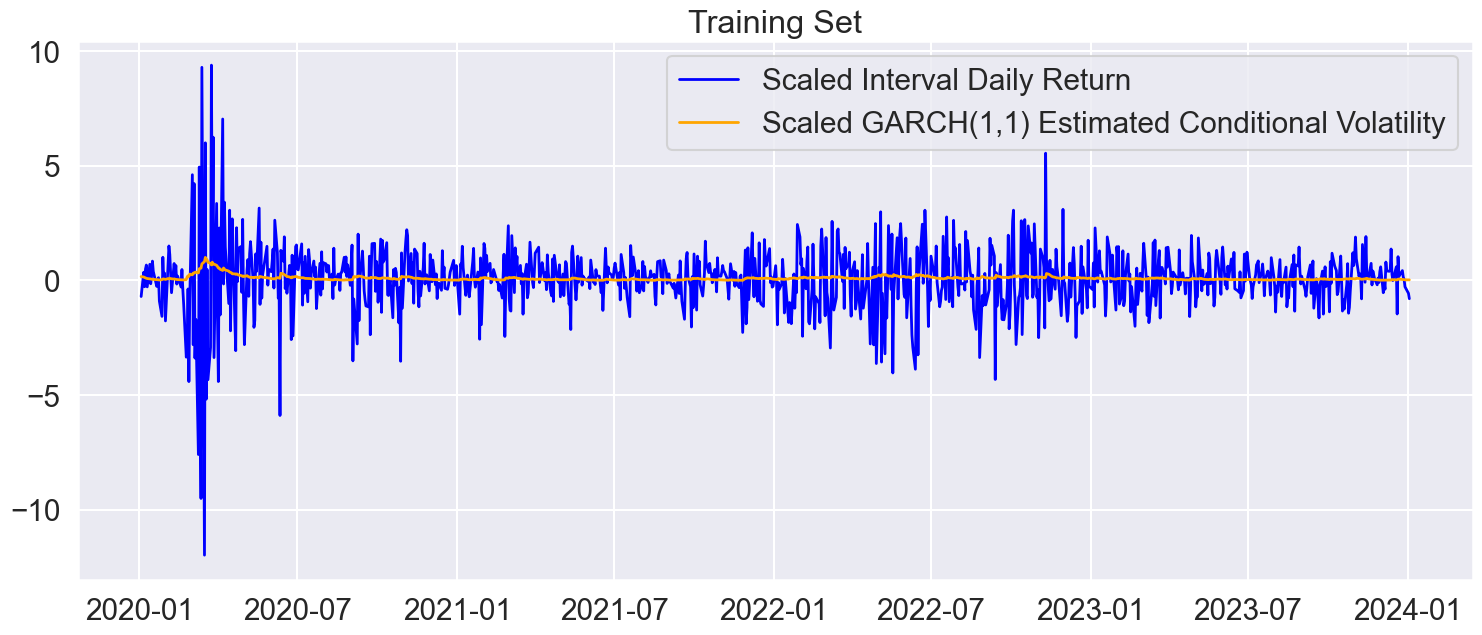

In [57]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

In [58]:
# One step expanding window forecast
# Initializing rolling_forecast
n_future = 250
rolling_forecasts = []
idx = df.index

# Iterate over each time step in the validation set
for i in range(len(test_idx)):
    # Get the data at all previous time steps
    idx = test_idx[i]
    train = df.returns[:idx]
    
    # Train model using all previous time steps' data
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # Make prediction n_future days out
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # Get the sqrt of average n_future days variance
    pred = np.sqrt(np.mean(vaR))

    # Append to rolling_forecasts list
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=test_idx)

In [59]:
# Transform predictions using fitted scaler
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

In [60]:
# Plotting model predictions vs. target values
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(r_train, color='gray',  ls=':',
                label=f"Scaled Current Daily Return")
        
        plt.plot(y_true, color='orange', lw=2, 
                label=f"Target Retrun")
        plt.plot(y_pred, color='blue', lw=8.5,
                label=f'Forecasted Return')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)
        plt.show()

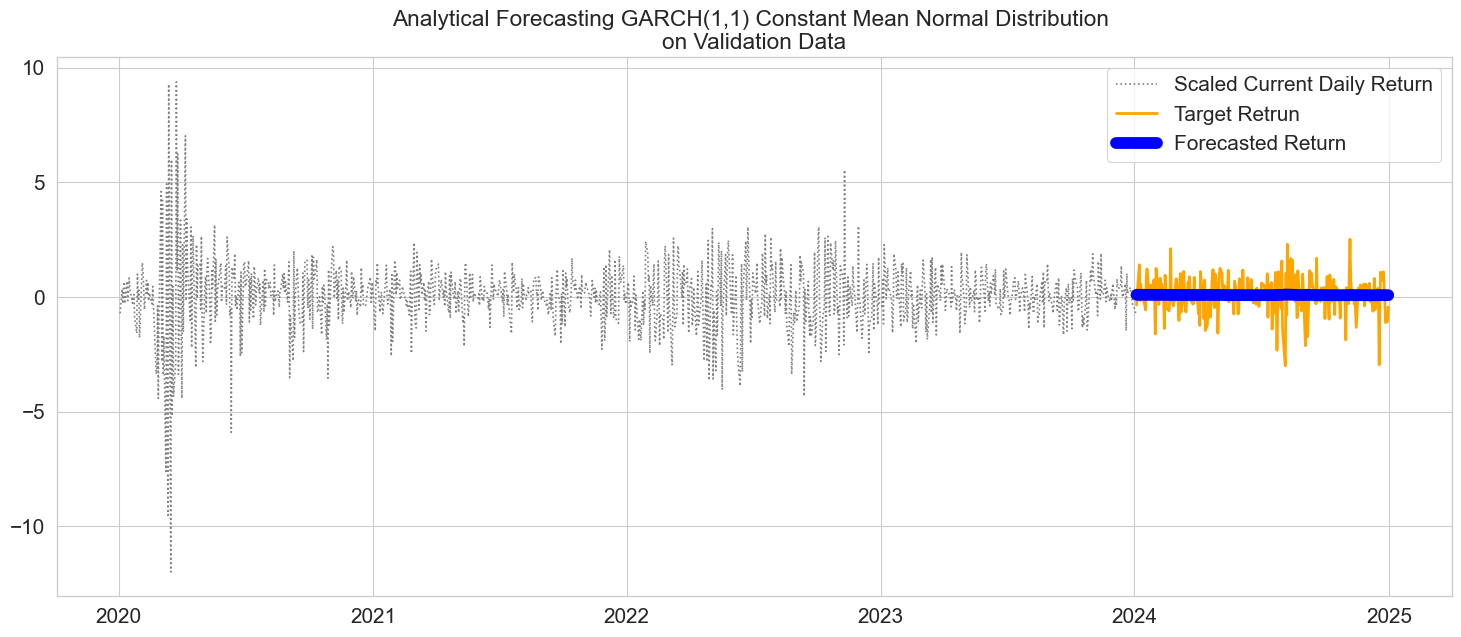

In [61]:
# Plotting predictions vs. target values on validation set
viz_model(r_test, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

### Performance Metrics

With financial time series, if we simply shift through the historical data, experimenting with various methodologies, parameters, and timescales, we are practically sure to find a strategy that is profitable in-sample at some point. However, the goal of "forecasting" is to predict the future based on current data, and a model that performs well on training data may not be the greatest for out-of-sample generalization (or **overfitting**, as mentioned in the [Session 1 YouTube playlist](https://www.youtube.com/playlist?list=PLHHpSPMS-hkgPYHIilA-Ag-duv9Z4xSr9) from the real-world traders). In the continually changing financial markets, where the stakes are high, avoiding/minimizing overfitting is even more important. As mentioned in the videos of [Session 1 Introduction to Data Science in Asset Management YouTube playlist](https://www.youtube.com/playlist?list=PLHHpSPMS-hkgPYHIilA-Ag-duv9Z4xSr9), the real-world overfitting is the main concern or mistake as the fund managers shared their suggestions.

**RMSPE (Root Mean Squared Percentage Error)** and **RMSE (Root Mean Square Errors)** are the two major metrics utilize, with RMSPE taking priority. Because of the degree of freedom in frequency/interval window selection, timescaling is critical in the computation of volatility.
As a result, we believe RMSPE is a better statistic for capturing degree of errors compared to desired target values than other metrics.
RMSPE would also penalize huge errors more strongly than normal MAPE (Mean Absolute Percentage Error), which is what we will do here. 

The RMSE and RMSPE of different models' validation set forecasting performance would be tracked to determine their ability to generalize on out-of-sample data. 

In [62]:
# Define root mean squared percentage error function
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [63]:
# Define root mean squared error function
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [64]:
# Initiate a dataframe for model performance tracking & comparison 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [65]:
# A function that logs model name, rmse and rmpse into perf_df for easy comparison later
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [66]:
# Append metrics outputs to perf_df dataframe
log_perf(r_test, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

,Model,Validation RMSPE,Validation RMSE
0,"GARCH(1,1), Constant Mean, Normal Dist",10.858432,0.795246


Next, we would inspect the estimated residuals from this first GARCH model.

### Diagnostic checking for GARCH(1,1) Model

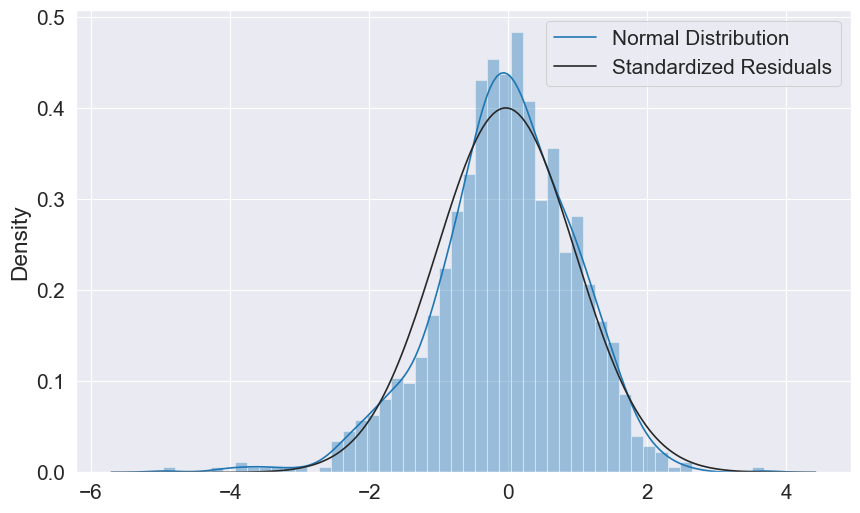

In [67]:
# inspecting the residuals
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# Standardizing residuals
gm_std_resid = gm_resid / gm_std

# Visualizing standardized residuals vs. a normal distribution
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

By default, basic GARCH is based on some assumptions that the residuals and the mean return are both normally distributed. However, more often than not, financial time series data does not follow a normal distribution, and it's more likely to observe extreme positive and negative values that are far away from the mean. 

Fortunately, there're certain parameters that can be specified in the `arch_model` library to make it more representative of real financial data:
- `'dist'` can be set to `t` for Student's T or `skewt` for skewed Student's T distribution (Student's T distribution is also symmetric and bell-shaped like normal distribution; however it has higher peak and fatter tails allowing more values lying further away from the mean).

Looking at the plot above of the standardized residuals, let us try skewed Student's T for the next fit.



### GARCH Model with Asymmetric Shocks Responses

The basic GARCH model assumes positive and negative news have similar impact on volatility. However, in reality the market tends to "*take the stairs up and the elevator down*". In other words, the impact is usually asymmetric, and negative impacts tends to affect the volatility more than positive ones.

There's another member in the GARCH family that accounts for assymmetry of shocks reponses called **GJR-GARCH** (short for **Glosten-Jagannathan-Runkle GARCH**).

Additional inputs can be used to construct other models. In this case, by setting `o` to 1, which means the model would include one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics.

In [68]:
# Set seed for reproducibility
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_4 = gjr_gm.fit(disp='off')
print(result_4.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -1502.45
Distribution:      Standardized Skew Student's t   AIC:                           3018.90
Method:                       Maximum Likelihood   BIC:                           3053.31
                                                   No. Observations:                 1007
Date:                           Fri, Oct 10 2025   Df Residuals:                     1006
Time:                                   16:00:33   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

In [69]:
# Get volatility scaler & scaled conditional volatility from model result
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_4)

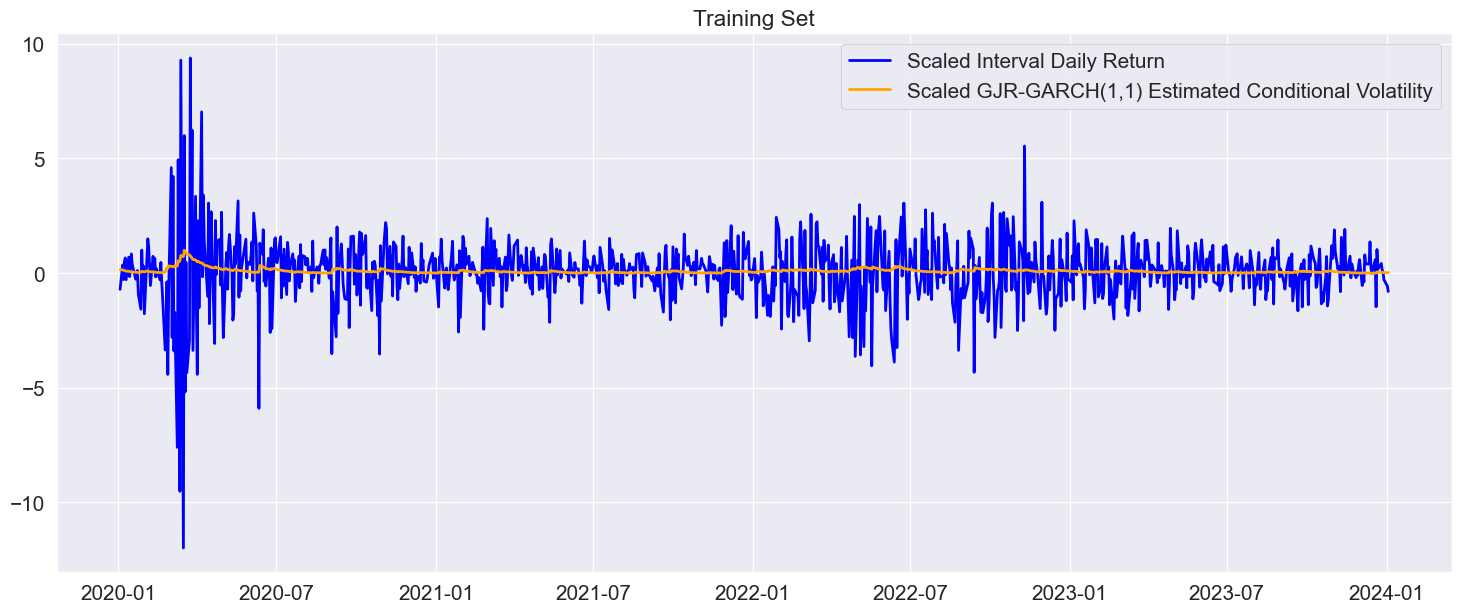

In [70]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [71]:
# Rolling window forecast
# Initializing rolling_forecasts values list
rolling_forecasts = []

# Iterate over each time step in the validation set
for i in range(len(test_idx)):
    # Get the data at all previous time steps
    idx = test_idx[i]
    train = df.returns[:idx].dropna()

    # Train model using all previous time steps' data
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # Make prediction n_future days out
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # Append to rolling_forecasts list
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=test_idx)

In [72]:
# Transform predictions using fitted scaler
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

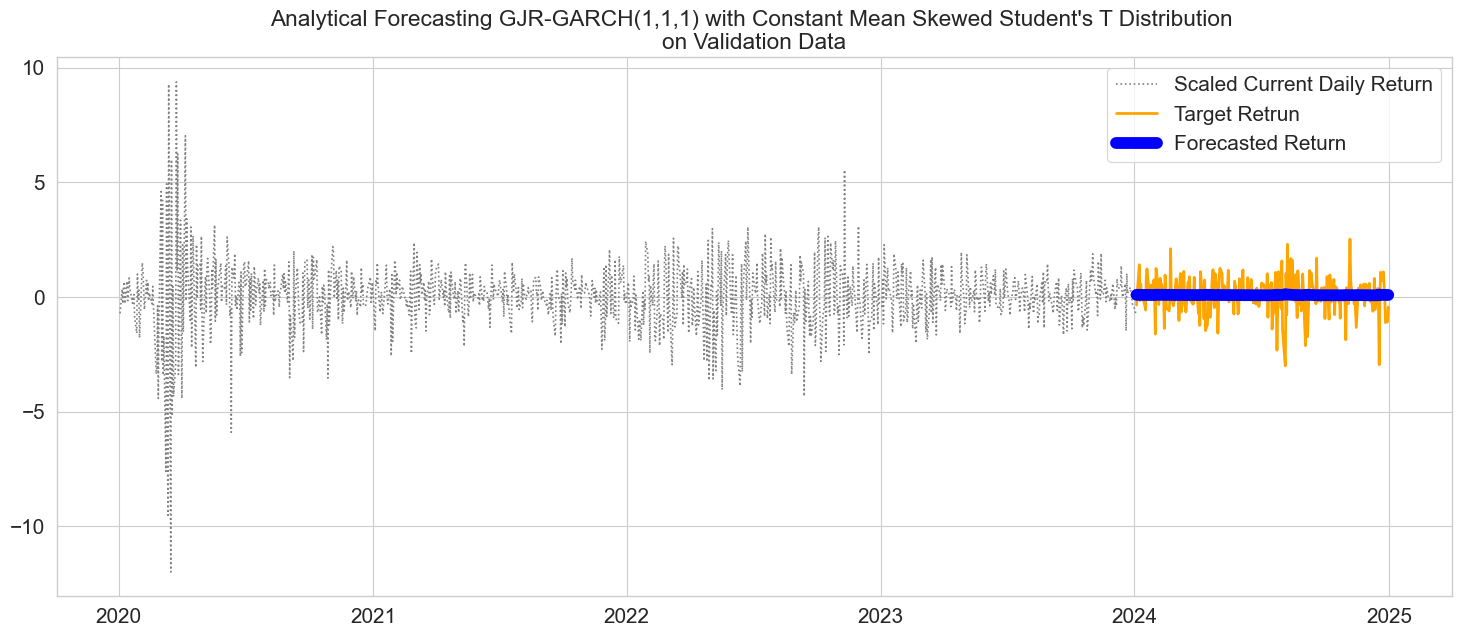

In [73]:
# Plotting predictions vs. target values on validation set
viz_model(r_test, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [74]:
# Append metrics outputs to perf_df dataframe
log_perf(r_test, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

,Model,Validation RMSPE,Validation RMSE
0,"GARCH(1,1), Constant Mean, Normal Dist",10.858432,0.795246
1,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",10.627112,0.796736


# Make forecast with GARCH models

We will practice forecasting basic volatility.

We will call ``.forecast()`` to make a prediction. By default it produces a ``1-step`` ahead estimate. You can use ``horizon = n`` to specify longer forward periods.


In [75]:
rolling_predictions = []
test_size = 250
for i in range(test_size):
  train = data_return[:-(test_size-i)]
  model = arch_model(train['returns'], p=1, q=1)
  model_fit = model.fit(disp='off')
  pred = model_fit.forecast(horizon=1)
  rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [76]:
rolling_predictions = pd.Series(rolling_predictions, index=data_return["returns"].index[-250:])

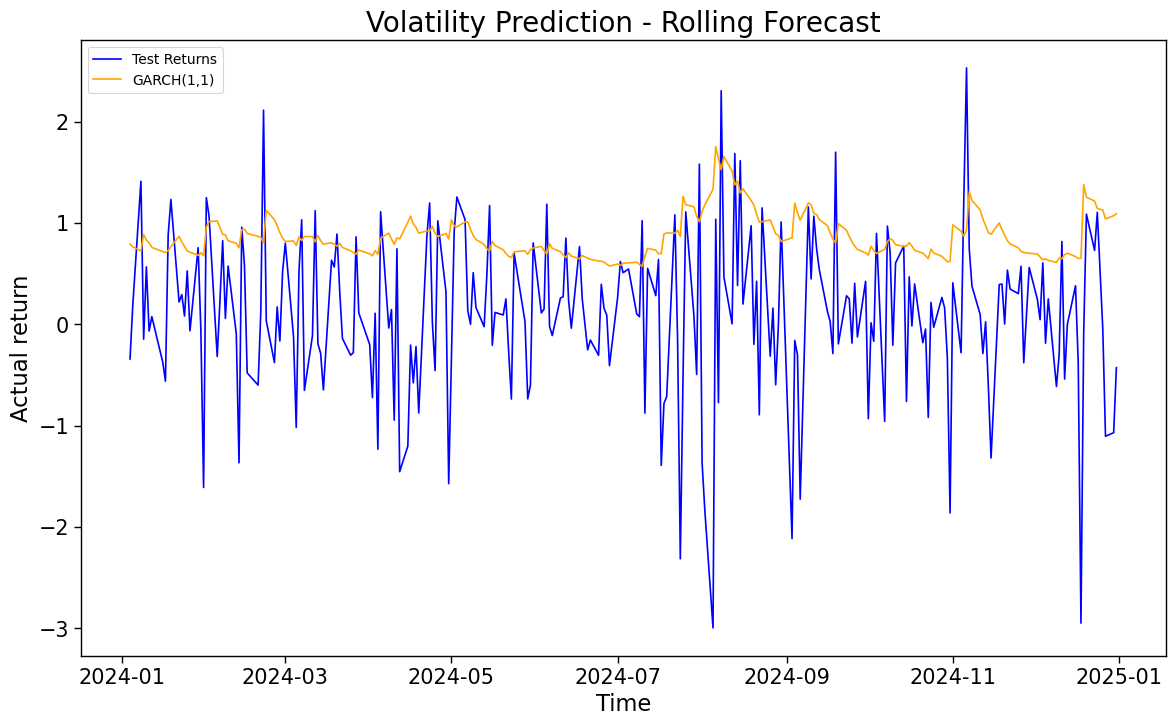

In [77]:
plt.figure(figsize=(14,8))
true, = plt.plot(data_return.returns[-250:],color = 'blue')
preds, = plt.plot(rolling_predictions,color = 'orange')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['Test Returns', 'GARCH(1,1)'], loc='upper left', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Actual return')
plt.show()

> We see on the chart, the blue line is still the Returns of the Asset or Market Index between  Jan., 2024 and Dec., 2024, the orange line is the prediction of the GARCH process but that prediction is volatility, we seeing that when the blue line the returns are not very jumpy the orange line is also pretty stable.

## Forecast Performance Measures

**Accuracy Metrics for Time Series Forecast**

The commonly used accuracy metrics to judge forecasts are:

1. Mean Absolute Percentage Error (MAPE)
2. Mean Squared Error (MSE)
3. Mean Absolute Error (MAE)
4. Root Mean Squared Error (RMSE)

In [78]:
# report performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(test['returns'], rolling_predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test['returns'], rolling_predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test['returns'], rolling_predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(rolling_predictions - test['returns'])/np.abs(test['returns']))
print('MAPE: '+str(mape))

MSE: 1.235451130734696
MAE: 0.8701729270045045
RMSE: 1.1115084933254877
MAPE: 15.742469991663738


We use the GARCH(1,1) model for the volatility prediction in the next 7 Days.

In [79]:
# Make 7-period ahead forecast
predd = result_1.forecast(horizon=7)
future_datess = [train["returns"].index[-1] + timedelta(days=i) for i in range(1,8)]
predd = pd.Series(np.sqrt(predd.variance.values[-1,:]), index=future_datess)

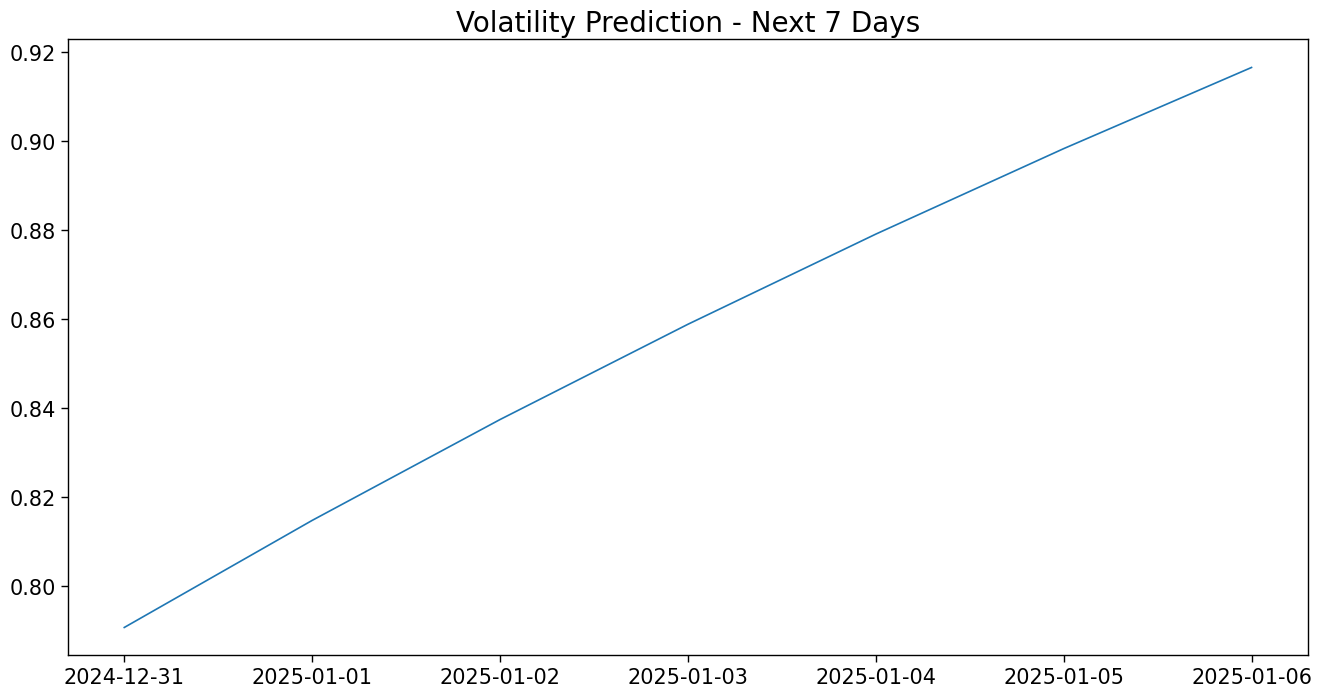

In [80]:
plt.figure(figsize=(16,8))
plt.plot(predd)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)
plt.show()

We see that it starts pretty low on 31 Dec 2024 then it goes pretty high on 06 January 2025.
Volatility prediction to help make judgments about whether we should buy
or sell a stock based on if it’s going to be very volatile in a certain time period
or expected to be not as volatile.

# References

- [Kaggle](https://www.kaggle.com)

For detailed ARIMA examples, see the following Kaggle pages:
- [stock-market-forecasting-arima](https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima)
- [timeseries-analysis-a-complete-guide](https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide)
- [arima-model-for-time-series-forecasting](https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting)

For more ARCH and GARCH examples, see these webpages:
- [ARCH/GARCH Volatility Forecasting](https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/)
- [Volatility Forecasting](https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html)